<a href="https://colab.research.google.com/github/rht6226/InnoHAR-NeuralNet/blob/master/InnoHAR_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# InnoHAR architecture based Model


In this module we will be training a model which uses the InnoHAR Architecture for Human Activity recognition on UCI HAR Mobile Dataset. 

The InnoHAR architecture is inspired by google's Inception Model

In [1]:
# Imports
import numpy as np
from keras.utils import to_categorical
import json
import matplotlib

## Loading the dataset

In [2]:
# Get class from file
from drive.MyDrive.InnoHAR.DatasetLoader import UciMobileDataset

In [3]:
uci = UciMobileDataset(filepath='/content/drive/MyDrive/InnoHAR/ProcessedDataset/')
uci.summary()

UCI Human Activity Recognition Dataset: 
Shape of training data = X:(7352, 128, 9), y: (7352, 6)
Shape of testing data = X:(2947, 128, 9), y: (2947, 6)


## Creating the Model

In [4]:
# imports
import keras
from keras import regularizers
from keras.models import Sequential
from keras.layers import MaxPooling1D, Conv1D, Flatten, Dense, Concatenate, GRU, Input, InputLayer
from keras.utils.vis_utils import plot_model

In [5]:
# This class defines the Inception Layer
class Incept1D(keras.Model):
    def __init__(self, c1, c2, c3, c4):
        super(Incept1D, self).__init__()
        self.p1_1x1_conv = Conv1D(filters=c1, kernel_size=1, activation='relu', padding='same')

        self.p2_1x1_conv = Conv1D(filters=c2[0], kernel_size=1, activation='relu', padding='same')
        self.p2_1x3_conv = Conv1D(filters=c2[1], kernel_size=3, activation='relu', padding='same')

        self.p3_1x1_conv = Conv1D(filters=c3[0], kernel_size=1, activation='relu', padding='same')
        self.p3_1x5_conv = Conv1D(filters=c3[1], kernel_size=3, activation='relu', padding='same')

        self.p4_1x3_maxpool = MaxPooling1D(pool_size=3, strides=1, padding='same')
        self.p4_1x1_conv = Conv1D(filters=c4, kernel_size=1, padding='same', activation='relu')


    def call(self, x):
        p1 = self.p1_1x1_conv(x)
        p2 = self.p2_1x3_conv(self.p2_1x1_conv(x))
        p3 = self.p3_1x5_conv(self.p3_1x1_conv(x))
        p4 = self.p4_1x1_conv(self.p4_1x3_maxpool(x))
        # Concatenate the outputs on the channel dimension
        return Concatenate()([p1, p2, p3, p4])

In [6]:
def get_model(trainX, trainy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

    # Model Definitions
    model = Sequential(name='InnoHAR')
    # Input Layer
    model.add(InputLayer(input_shape=(n_timesteps, n_features)))
    model.add(Incept1D(64, (32, 64), (32, 64), 64))
    model.add(Incept1D(56, (32, 64), (32, 64), 64))
    model.add(Incept1D(32, (32, 56), (32, 56), 32))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(Incept1D(32, (16, 32), (16, 32), 24))
    model.add(MaxPooling1D(pool_size=2, padding='same'))
    model.add(GRU(120, return_sequences=True))
    model.add(GRU(40))
    model.add(Dense(n_outputs, activation='softmax',
                    kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4), 
                    bias_regularizer=regularizers.l2(1e-4), 
                    activity_regularizer=regularizers.l2(1e-5)
                    ))

    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return model

In [7]:
model = get_model(uci.trainX, uci.trainy)
model.summary()

Model: "InnoHAR"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
incept1d (Incept1D)          (None, 128, 256)          14336     
_________________________________________________________________
incept1d_1 (Incept1D)        (None, 128, 248)          59704     
_________________________________________________________________
incept1d_2 (Incept1D)        (None, 128, 176)          42736     
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 64, 176)           0         
_________________________________________________________________
incept1d_3 (Incept1D)        (None, 64, 120)           18712     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 32, 120)           0         
_________________________________________________________________
gru (GRU)                    (None, 32, 120)           8712

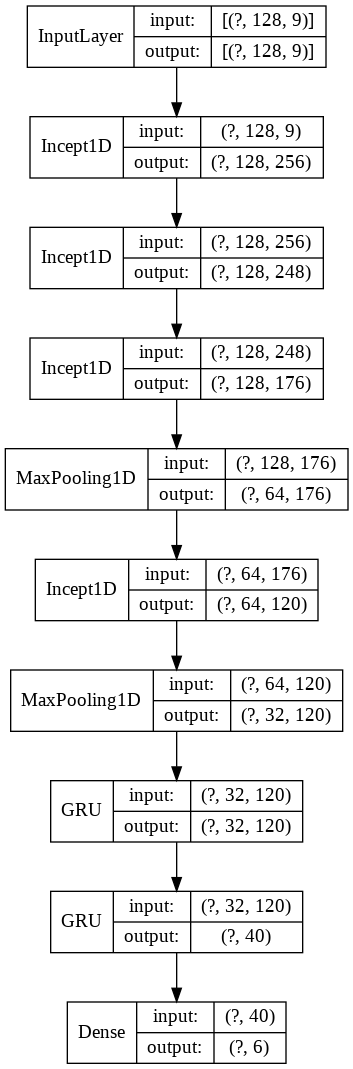

In [8]:
plot_model(model, show_shapes=True, show_layer_names=False)

## Training the Models

Only one instance of a trained model cannot be used to determine the model performance. Hence we will be training Multiple instances of the same InnoHAR model and then we will find out the average accuracy.

In [9]:
def train_models(X=uci.trainX, y=uci.trainy, num_instances=50, verbose=1, epochs=30, batch_size=64, valid_data = (uci.testX, uci.testy)):

    # Here we will store all the models
    modelList = []

    # Training multiple models at the same time for finding average accuracy
    for i in range(num_instances):
        print("\n<========== Now training model - {} ...... =======>".format(i))

        model = get_model(X, y)
        history = model.fit(X, y, epochs=epochs, verbose=1, batch_size=batch_size, validation_data=valid_data)

        print("<==================================================>\n")

        # Finding accuracy
        _, accuracy = model.evaluate(valid_data[0], valid_data[1], batch_size=32, verbose=0)

        modelList.append({
            "model": model,
            "history": history,
            "accuracy": accuracy
        })

    return modelList

In [10]:
modelList = train_models()


<========== Now training model - 0 ...... =======>
Epoch 1/30
115/115 [==============================] - 4s 37ms/step - loss: 0.6035 - accuracy: 0.7519 - val_loss: 0.4868 - val_accuracy: 0.8768
Epoch 2/30
115/115 [==============================] - 2s 19ms/step - loss: 0.1683 - accuracy: 0.9370 - val_loss: 0.2680 - val_accuracy: 0.9094
Epoch 3/30
115/115 [==============================] - 2s 19ms/step - loss: 0.1259 - accuracy: 0.9499 - val_loss: 0.2524 - val_accuracy: 0.9189
Epoch 4/30
115/115 [==============================] - 2s 20ms/step - loss: 0.1231 - accuracy: 0.9504 - val_loss: 0.2509 - val_accuracy: 0.9023
Epoch 5/30
115/115 [==============================] - 2s 21ms/step - loss: 0.1191 - accuracy: 0.9502 - val_loss: 0.2392 - val_accuracy: 0.9179
Epoch 6/30
115/115 [==============================] - 2s 21ms/step - loss: 0.1061 - accuracy: 0.9538 - val_loss: 0.2264 - val_accuracy: 0.9260
Epoch 7/30
115/115 [==============================] - 2s 21ms/step - loss: 0.1013 - accura

# Compare different instances

We will compare the different instances of trained model to find the one which gives the best performance. We will also find the average accuracy for the trained models.

In [11]:
# Imports
import matplotlib.pyplot as plt
from statistics import mean 

In [12]:
def plot_accuracies(modelList, modelName, figureSize=[8, 8]):
    accuracies = []
    for modelDict in modelList:
        accuracies.append(modelDict['accuracy'])
    mean_accuracy = mean(accuracies)
    matplotlib.rcParams['figure.figsize'] = figureSize
    plt.plot(accuracies)
    plt.axhline(y=mean_accuracy, color='r', linestyle='-')
    plt.title('Model accuracy for different instances of - {}'.format(modelName))
    plt.ylabel('accuracy')
    plt.xlabel('Instance #')
    plt.legend(['Instance Accuracy', 'Mean Accuracy'], loc='lower right')
    plt.show()
    
    print("\n\nThe average accuracy of this model was found out to be: {}".format(mean_accuracy))

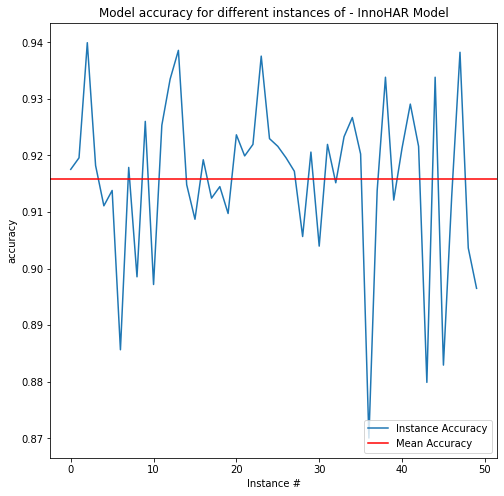



The average accuracy of this model was found out to be: 0.9158805537223816


In [13]:
plot_accuracies(modelList, modelName='InnoHAR Model')

## Selecting Model closest to Mean

here we will be selecting a model instance whose performance is the closest to the mean accuracy. This will help us in comparision between various models.

In [14]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import get_average_model

In [15]:
model, history = get_average_model(modelList)

In [16]:
# Saving the model
import tensorflow as tf    
tf.keras.models.save_model(
    model,
    "Inception_GRU_UCI_HAR.model",
    overwrite=True,
    include_optimizer=True
)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: Inception_GRU_UCI_HAR.model/assets


## Plotting Accuracy and Losses

In [17]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_model_accuracy, plot_model_loss

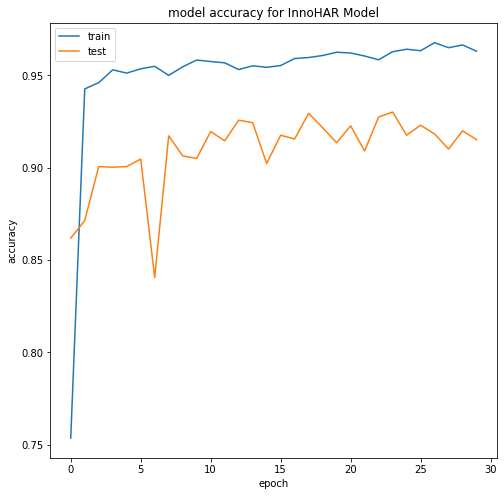

In [18]:
plot_model_accuracy('InnoHAR Model', history=history)

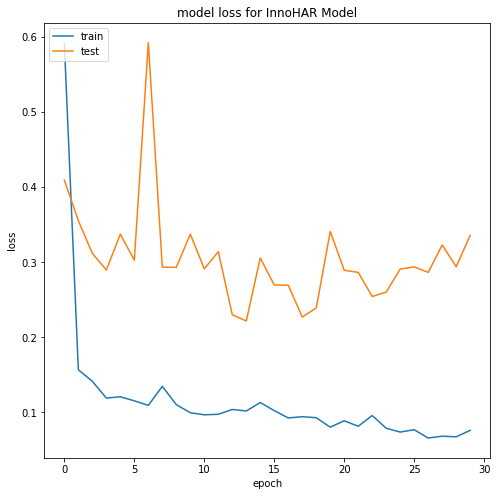

In [19]:
plot_model_loss('InnoHAR Model', history=history)

## Plotting Confusion Matrix

In [20]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import plot_cm

Confusion matrix, without normalization


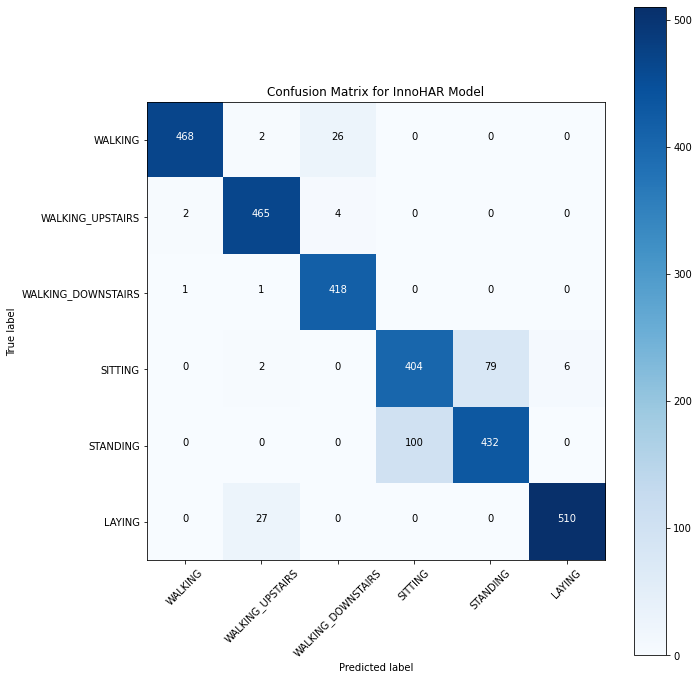

In [21]:
plot_cm(model, test_data=(uci.testX, uci.testy), title='Confusion Matrix for InnoHAR Model')

## Classification Report

In [22]:
# Get functions from file
from drive.MyDrive.InnoHAR.helpers import print_classification_report

In [23]:
print_classification_report(model, test_data=(uci.testX, uci.testy), title='InnoHAR Model')

Classification Report for 'InnoHAR Model': 

                    precision    recall  f1-score   support

           WALKING    0.99363   0.94355   0.96794       496
  WALKING_UPSTAIRS    0.93561   0.98726   0.96074       471
WALKING_DOWNSTAIRS    0.93304   0.99524   0.96313       420
           SITTING    0.80159   0.82281   0.81206       491
          STANDING    0.84540   0.81203   0.82838       532
            LAYING    0.98837   0.94972   0.96866       537

          accuracy                        0.91517      2947
         macro avg    0.91627   0.91843   0.91682      2947
      weighted avg    0.91601   0.91517   0.91507      2947

